In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import os, sys

def get_dir_n_levels_up(path, n):
    # Go up n levels from the given path
    for _ in range(n):
        path = os.path.dirname(path)
    return path

proj_root = get_dir_n_levels_up(os.path.abspath("__file__"), 4)
sys.path.append(proj_root)

import warnings
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

warnings.filterwarnings("ignore")

from dqn.opinion_dynamics.utils.experiment import process_experiment


In [22]:
# experiment_sub_dir = "2025May02-101004_configs" # excellent run
# experiment_sub_dir = "2025Jul09-171538_configs" # good latest run

experiment_sub_dir = "2025Aug30-132637_configs" 

exp_path = os.path.join(os.path.abspath("."), "results", experiment_sub_dir)
df = process_experiment(
    exp_path
)
df.columns


Index(['epoch_type', 'frame_stamp', 'greedy_epsilon', 'episode_rewards_min',
       'episode_rewards_max', 'episode_rewards_mean', 'episode_rewards_median',
       'episode_rewards_std', 'episode_discounted_rewards_min',
       'episode_discounted_rewards_max', 'episode_discounted_rewards_mean',
       'episode_discounted_rewards_median', 'episode_discounted_rewards_std',
       'episode_frames_min', 'episode_frames_max', 'episode_frames_mean',
       'episode_frames_median', 'episode_frames_std', 'episode_losses_min',
       'episode_losses_max', 'episode_losses_mean', 'episode_losses_median',
       'episode_losses_std', 'episode_max_qs_min', 'episode_max_qs_max',
       'episode_max_qs_mean', 'episode_max_qs_median', 'episode_max_qs_std',
       'policy_trained_times', 'target_trained_times', 'epoch_time',
       'sub_exp_cfg_optim.args_.eps', 'sub_exp_cfg_optim.args_.lr',
       'sub_exp_cfg_agent_params.args_.betas',
       'sub_exp_cfg_agent_params.model', 'sub_exp_cfg_experiment

In [23]:
df

,epoch_type,frame_stamp,greedy_epsilon,episode_rewards_min,episode_rewards_max,episode_rewards_mean,episode_rewards_median,episode_rewards_std,episode_discounted_rewards_min,episode_discounted_rewards_max,...,target_trained_times,epoch_time,sub_exp_cfg_optim.args_.eps,sub_exp_cfg_optim.args_.lr,sub_exp_cfg_agent_params.args_.betas,sub_exp_cfg_agent_params.model,sub_exp_cfg_experiment,sub_experiment_path,seed,experiment_name
0,training,200000,0.907375,-21.311181,-7.313749,-13.088833,-12.965404,2.161265,-17.138206,-5.722502,...,192.0,0 days 00:07:06.463382,1e-09,1e-06,"[0, 1, 2]",OpinionNetFixedW,opinion_agent_dqn_fixed_dist_fixed_steps,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.eps_1e-09__optim.args_.lr_1e-...
1,training,400000,0.812375,-22.869381,-7.067742,-13.555417,-13.355640,2.411626,-18.381781,-5.653397,...,200.0,0 days 00:07:44.591472,1e-09,1e-06,"[0, 1, 2]",OpinionNetFixedW,opinion_agent_dqn_fixed_dist_fixed_steps,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.eps_1e-09__optim.args_.lr_1e-...
2,training,600000,0.717375,-29.045010,-7.262645,-14.412945,-14.205236,2.758383,-22.501321,-5.787408,...,200.0,0 days 00:07:57.004538,1e-09,1e-06,"[0, 1, 2]",OpinionNetFixedW,opinion_agent_dqn_fixed_dist_fixed_steps,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.eps_1e-09__optim.args_.lr_1e-...
3,training,800000,0.622375,-26.864162,-7.434794,-15.450084,-15.162936,3.214437,-21.034683,-5.931133,...,200.0,0 days 00:07:59.847435,1e-09,1e-06,"[0, 1, 2]",OpinionNetFixedW,opinion_agent_dqn_fixed_dist_fixed_steps,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.eps_1e-09__optim.args_.lr_1e-...
4,training,1000000,0.527375,-38.618659,-7.130184,-16.771524,-16.400404,3.826748,-28.562329,-5.632597,...,200.0,0 days 00:07:47.518452,1e-09,1e-06,"[0, 1, 2]",OpinionNetFixedW,opinion_agent_dqn_fixed_dist_fixed_steps,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.eps_1e-09__optim.args_.lr_1e-...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,validation,1200000,NaN,-12.470375,-9.261328,-10.826950,-10.417305,1.311489,-10.749731,-7.815449,...,NaN,0 days 00:00:01.594909,1e-08,5e-06,"[0, 1, 2]",OpinionNetFixedW,opinion_agent_dqn_fixed_dist_fixed_steps,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0003_optim.args_.eps_1e-08__optim.args_.lr_5e-...
76,validation,1400000,NaN,-12.402688,-9.182570,-10.514202,-10.335044,1.289857,-10.716678,-7.775552,...,NaN,0 days 00:00:01.591857,1e-08,5e-06,"[0, 1, 2]",OpinionNetFixedW,opinion_agent_dqn_fixed_dist_fixed_steps,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0003_optim.args_.eps_1e-08__optim.args_.lr_5e-...
77,validation,1600000,NaN,-12.409676,-9.118922,-10.606215,-10.277047,1.384109,-10.733991,-7.745023,...,NaN,0 days 00:00:04.150931,1e-08,5e-06,"[0, 1, 2]",OpinionNetFixedW,opinion_agent_dqn_fixed_dist_fixed_steps,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0003_optim.args_.eps_1e-08__optim.args_.lr_5e-...
78,validation,1800000,NaN,-12.297575,-9.055278,-10.631555,-10.226556,1.326565,-10.668842,-7.714497,...,NaN,0 days 00:00:04.179902,1e-08,5e-06,"[0, 1, 2]",OpinionNetFixedW,opinion_agent_dqn_fixed_dist_fixed_steps,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0003_optim.args_.eps_1e-08__optim.args_.lr_5e-...


In [24]:
df[df['epoch_type'] == 'validation']
# df[df['epoch_type'] == 'training']


,epoch_type,frame_stamp,greedy_epsilon,episode_rewards_min,episode_rewards_max,episode_rewards_mean,episode_rewards_median,episode_rewards_std,episode_discounted_rewards_min,episode_discounted_rewards_max,...,target_trained_times,epoch_time,sub_exp_cfg_optim.args_.eps,sub_exp_cfg_optim.args_.lr,sub_exp_cfg_agent_params.args_.betas,sub_exp_cfg_agent_params.model,sub_exp_cfg_experiment,sub_experiment_path,seed,experiment_name
10,validation,200000,NaN,-35.184081,-29.811768,-31.780858,-31.027369,2.212836,-25.550456,-21.195178,...,NaN,0 days 00:00:01.385041,1e-09,1e-06,"[0, 1, 2]",OpinionNetFixedW,opinion_agent_dqn_fixed_dist_fixed_steps,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.eps_1e-09__optim.args_.lr_1e-...
11,validation,400000,NaN,-39.636197,-33.777789,-36.050330,-34.282496,2.680301,-28.470148,-24.082863,...,NaN,0 days 00:00:01.472678,1e-09,1e-06,"[0, 1, 2]",OpinionNetFixedW,opinion_agent_dqn_fixed_dist_fixed_steps,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.eps_1e-09__optim.args_.lr_1e-...
12,validation,600000,NaN,-43.158643,-35.032837,-38.286921,-35.994039,3.643838,-30.815721,-24.972930,...,NaN,0 days 00:00:01.457501,1e-09,1e-06,"[0, 1, 2]",OpinionNetFixedW,opinion_agent_dqn_fixed_dist_fixed_steps,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.eps_1e-09__optim.args_.lr_1e-...
13,validation,800000,NaN,-47.702068,-36.699691,-40.706713,-38.273323,4.457221,-33.985351,-26.241533,...,NaN,0 days 00:00:01.940597,1e-09,1e-06,"[0, 1, 2]",OpinionNetFixedW,opinion_agent_dqn_fixed_dist_fixed_steps,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.eps_1e-09__optim.args_.lr_1e-...
14,validation,1000000,NaN,-52.401072,-37.842864,-43.817171,-40.611414,6.459627,-37.203748,-26.699528,...,NaN,0 days 00:00:01.528087,1e-09,1e-06,"[0, 1, 2]",OpinionNetFixedW,opinion_agent_dqn_fixed_dist_fixed_steps,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.eps_1e-09__optim.args_.lr_1e-...
15,validation,1200000,NaN,-47.298898,-37.087070,-41.412010,-38.703782,4.410017,-33.631567,-26.335356,...,NaN,0 days 00:00:01.619321,1e-09,1e-06,"[0, 1, 2]",OpinionNetFixedW,opinion_agent_dqn_fixed_dist_fixed_steps,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.eps_1e-09__optim.args_.lr_1e-...
16,validation,1400000,NaN,-38.401531,-34.282496,-35.824068,-35.303671,1.686280,-27.716099,-24.238397,...,NaN,0 days 00:00:01.570198,1e-09,1e-06,"[0, 1, 2]",OpinionNetFixedW,opinion_agent_dqn_fixed_dist_fixed_steps,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.eps_1e-09__optim.args_.lr_1e-...
17,validation,1600000,NaN,-33.894994,-29.811768,-31.617377,-31.027369,1.765366,-24.715806,-21.195178,...,NaN,0 days 00:00:04.042284,1e-09,1e-06,"[0, 1, 2]",OpinionNetFixedW,opinion_agent_dqn_fixed_dist_fixed_steps,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.eps_1e-09__optim.args_.lr_1e-...
18,validation,1800000,NaN,-26.980814,-25.118983,-25.963064,-25.620579,0.784468,-19.932177,-18.070595,...,NaN,0 days 00:00:04.129058,1e-09,1e-06,"[0, 1, 2]",OpinionNetFixedW,opinion_agent_dqn_fixed_dist_fixed_steps,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.eps_1e-09__optim.args_.lr_1e-...
19,validation,2000000,NaN,-21.139265,-17.939946,-19.255243,-18.886442,1.236277,-16.010981,-13.215450,...,NaN,0 days 00:00:04.320348,1e-09,1e-06,"[0, 1, 2]",OpinionNetFixedW,opinion_agent_dqn_fixed_dist_fixed_steps,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.eps_1e-09__optim.args_.lr_1e-...


In [25]:
# Define hyperparameter columns
hyperparam_columns = [col for col in df.columns if "sub_exp_cfg" in col]

# Group by hyperparameter values and compute mean episode_rewards_mean
averaged_results = df.groupby(hyperparam_columns, as_index=False).agg({
    'episode_rewards_mean': 'mean',  # Averaging the performance metric
    'sub_experiment_path': 'first'   # Keep a reference to an experiment path
})

# Find the best hyperparameter set based on the highest mean reward
best_row = averaged_results.loc[averaged_results['episode_rewards_mean'].idxmax()]

# Print the best experiment path and hyperparameters
print(f"Best hyperparameters:\n{best_row[hyperparam_columns]}")
print(f"Best mean reward: {best_row['episode_rewards_mean']}")

Best hyperparameters:
sub_exp_cfg_optim.args_.eps                                                1e-09
sub_exp_cfg_optim.args_.lr                                                 5e-06
sub_exp_cfg_agent_params.args_.betas                                   [0, 1, 2]
sub_exp_cfg_agent_params.model                                  OpinionNetFixedW
sub_exp_cfg_experiment                  opinion_agent_dqn_fixed_dist_fixed_steps
Name: 3, dtype: object
Best mean reward: -11.844823668461117


In [26]:
averaged_results

,sub_exp_cfg_optim.args_.eps,sub_exp_cfg_optim.args_.lr,sub_exp_cfg_agent_params.args_.betas,sub_exp_cfg_agent_params.model,sub_exp_cfg_experiment,episode_rewards_mean,sub_experiment_path
0,1e-08,1e-06,"[0, 1, 2]",OpinionNetFixedW,opinion_agent_dqn_fixed_dist_fixed_steps,-25.648785,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
1,1e-08,5e-06,"[0, 1, 2]",OpinionNetFixedW,opinion_agent_dqn_fixed_dist_fixed_steps,-11.871090,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
2,1e-09,1e-06,"[0, 1, 2]",OpinionNetFixedW,opinion_agent_dqn_fixed_dist_fixed_steps,-25.648014,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
3,1e-09,5e-06,"[0, 1, 2]",OpinionNetFixedW,opinion_agent_dqn_fixed_dist_fixed_steps,-11.844824,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...


In [27]:
# selected_metric = 'episode_rewards_mean'
# hue_col = "sub_exp_cfg_agent_params.args_.action_w_noise_amplitude"

# # Filter for validation episodes
# validation_df = df[df['epoch_type'] == 'validation']

# # Get the unique sorted frame_stamp values
# unique_frames = np.sort(validation_df['frame_stamp'].unique())
# N = 1
# # Get all frame_stamp values after the first N unique ones
# filtered_frames = unique_frames[N:]

# # Filter the DataFrame to only include rows with these frame_stamp values
# filtered_df = validation_df[validation_df['frame_stamp'].isin(filtered_frames)]

# plt.figure(figsize=(10, 6))
# sns.lineplot(data=filtered_df, x='frame_stamp', y=selected_metric, hue=hue_col)
# plt.ylabel(selected_metric)
# plt.xlabel('Frame Stamp')
# plt.show()

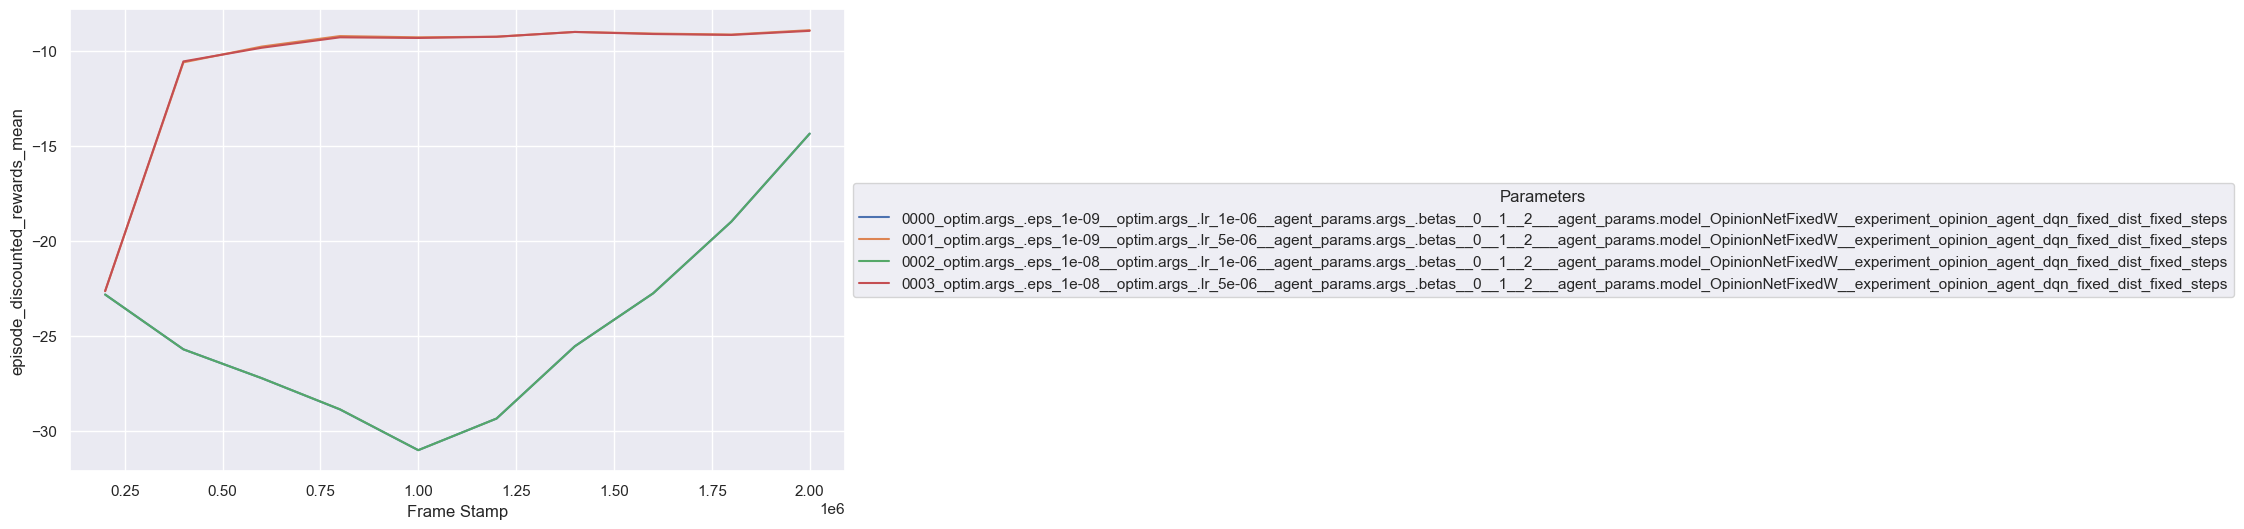

In [28]:

selected_metric = 'episode_discounted_rewards_mean'
# hue_col = "sub_exp_cfg_agent_params.args_.action_w_noise_amplitude"
hue_col = "experiment_name"

validation_df = df[df['epoch_type'] == 'validation']
# validation_df = df[df['epoch_type'] == 'training']


# Create a new figure for each environment
plt.figure(figsize=(10, 6))
# sns.lineplot(data=df, x='frame_stamp', y=selected_metric, hue='model')
sns.lineplot(data=validation_df, 
             x='frame_stamp', 
             y=selected_metric, 
             hue=hue_col,
            #  units='seed', # Comment this to see mean + cf
            #  estimator=None, # Comment this to see mean + cf
             )

plt.ylabel(selected_metric)
plt.xlabel('Frame Stamp')

# Place the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Parameters')
plt.show()

In [29]:
df.columns

Index(['epoch_type', 'frame_stamp', 'greedy_epsilon', 'episode_rewards_min',
       'episode_rewards_max', 'episode_rewards_mean', 'episode_rewards_median',
       'episode_rewards_std', 'episode_discounted_rewards_min',
       'episode_discounted_rewards_max', 'episode_discounted_rewards_mean',
       'episode_discounted_rewards_median', 'episode_discounted_rewards_std',
       'episode_frames_min', 'episode_frames_max', 'episode_frames_mean',
       'episode_frames_median', 'episode_frames_std', 'episode_losses_min',
       'episode_losses_max', 'episode_losses_mean', 'episode_losses_median',
       'episode_losses_std', 'episode_max_qs_min', 'episode_max_qs_max',
       'episode_max_qs_mean', 'episode_max_qs_median', 'episode_max_qs_std',
       'policy_trained_times', 'target_trained_times', 'epoch_time',
       'sub_exp_cfg_optim.args_.eps', 'sub_exp_cfg_optim.args_.lr',
       'sub_exp_cfg_agent_params.args_.betas',
       'sub_exp_cfg_agent_params.model', 'sub_exp_cfg_experiment

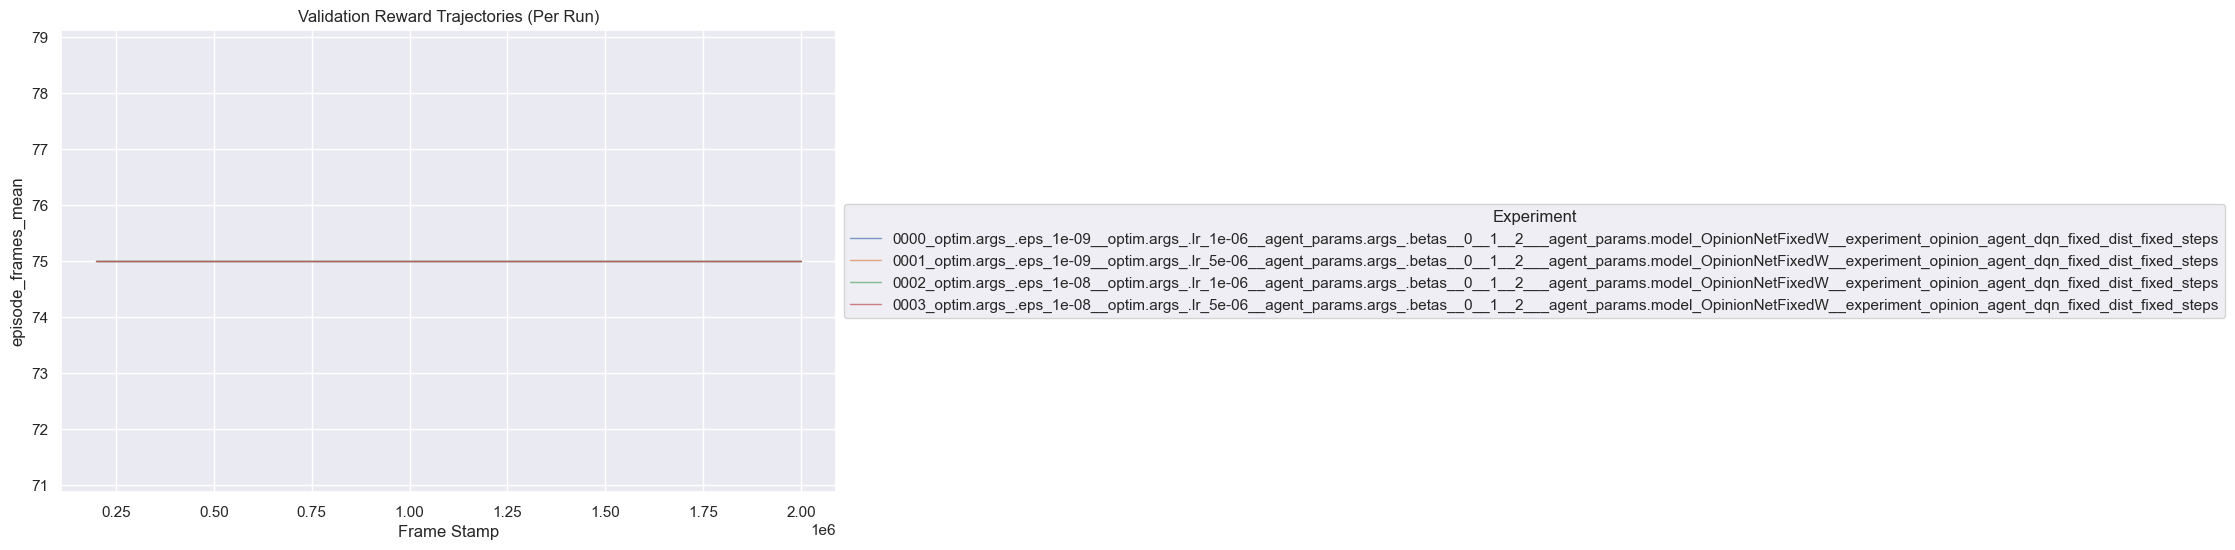

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

selected_metric = 'episode_frames_mean'
hue_col = "experiment_name"  # or another distinguishing column like "sub_experiment_path"

validation_df = df[df['epoch_type'] == 'validation']

# Plot individual lines for each run
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=validation_df,
    x='frame_stamp',
    y=selected_metric,
    hue=hue_col,
    estimator=None,  # ← disables aggregation
    units='sub_experiment_path',  # ← groups lines by unique run
    lw=1,  # line width
    alpha=0.7  # transparency
)

plt.ylabel(selected_metric)
plt.xlabel('Frame Stamp')
plt.title('Validation Reward Trajectories (Per Run)')

# Move legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Experiment')
plt.tight_layout()
plt.show()


In [31]:
### Select data

experiment_columns = [
    'epoch_type', 'frame_stamp',
    'episode_rewards_mean', 'episode_frames_mean', 
    'episode_discounted_rewards_mean',
    'policy_trained_times', 'target_trained_times', 'epoch_time', 
       'seed', 'experiment_name', "sub_experiment_path"
]
hyperparam_columns = [
   col for col in df.columns if "sub_exp_cfg" in col
]

cols_of_interest = experiment_columns + hyperparam_columns

sub_df = df[cols_of_interest]
sub_df = sub_df[sub_df['epoch_type'] == 'validation']
sub_df = sub_df[sub_df['frame_stamp'] == sub_df['frame_stamp'].max()]

sub_df 


,epoch_type,frame_stamp,episode_rewards_mean,episode_frames_mean,episode_discounted_rewards_mean,policy_trained_times,target_trained_times,epoch_time,seed,experiment_name,sub_experiment_path,sub_exp_cfg_optim.args_.eps,sub_exp_cfg_optim.args_.lr,sub_exp_cfg_agent_params.args_.betas,sub_exp_cfg_agent_params.model,sub_exp_cfg_experiment
19,validation,2000000,-19.255243,75.0,-14.347664,NaN,NaN,0 days 00:00:04.320348,0,0000_optim.args_.eps_1e-09__optim.args_.lr_1e-...,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1e-09,1e-06,"[0, 1, 2]",OpinionNetFixedW,opinion_agent_dqn_fixed_dist_fixed_steps
39,validation,2000000,-10.306417,75.0,-8.898826,NaN,NaN,0 days 00:00:03.981581,0,0001_optim.args_.eps_1e-09__optim.args_.lr_5e-...,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1e-09,5e-06,"[0, 1, 2]",OpinionNetFixedW,opinion_agent_dqn_fixed_dist_fixed_steps
59,validation,2000000,-19.255243,75.0,-14.347664,NaN,NaN,0 days 00:00:03.792745,0,0002_optim.args_.eps_1e-08__optim.args_.lr_1e-...,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1e-08,1e-06,"[0, 1, 2]",OpinionNetFixedW,opinion_agent_dqn_fixed_dist_fixed_steps
79,validation,2000000,-10.387444,75.0,-8.934751,NaN,NaN,0 days 00:00:02.696688,0,0003_optim.args_.eps_1e-08__optim.args_.lr_5e-...,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1e-08,5e-06,"[0, 1, 2]",OpinionNetFixedW,opinion_agent_dqn_fixed_dist_fixed_steps


In [32]:
agg_cols = [col for col in sub_df.columns if "sub_exp_cfg" in col]
aggregated_df = (
    sub_df.groupby(agg_cols)
    .agg(episode_discounted_rewards_mean=("episode_discounted_rewards_mean", "mean"))
    .reset_index()
)
aggregated_df

,sub_exp_cfg_optim.args_.eps,sub_exp_cfg_optim.args_.lr,sub_exp_cfg_agent_params.args_.betas,sub_exp_cfg_agent_params.model,sub_exp_cfg_experiment,episode_discounted_rewards_mean
0,1e-08,1e-06,"[0, 1, 2]",OpinionNetFixedW,opinion_agent_dqn_fixed_dist_fixed_steps,-14.347664
1,1e-08,5e-06,"[0, 1, 2]",OpinionNetFixedW,opinion_agent_dqn_fixed_dist_fixed_steps,-8.934751
2,1e-09,1e-06,"[0, 1, 2]",OpinionNetFixedW,opinion_agent_dqn_fixed_dist_fixed_steps,-14.347664
3,1e-09,5e-06,"[0, 1, 2]",OpinionNetFixedW,opinion_agent_dqn_fixed_dist_fixed_steps,-8.898826


In [33]:
sub_df.columns

Index(['epoch_type', 'frame_stamp', 'episode_rewards_mean',
       'episode_frames_mean', 'episode_discounted_rewards_mean',
       'policy_trained_times', 'target_trained_times', 'epoch_time', 'seed',
       'experiment_name', 'sub_experiment_path', 'sub_exp_cfg_optim.args_.eps',
       'sub_exp_cfg_optim.args_.lr', 'sub_exp_cfg_agent_params.args_.betas',
       'sub_exp_cfg_agent_params.model', 'sub_exp_cfg_experiment'],
      dtype='object')

In [34]:
print(sub_df[sub_df['episode_rewards_mean'] == sub_df['episode_rewards_mean'].max()]['sub_experiment_path'].values[0])



d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025Aug30-132637_configs\0001_optim.args_.eps_1e-09__optim.args_.lr_5e-06__agent_params.args_.betas__0__1__2___agent_params.model_OpinionNetFixedW__experiment_opinion_agent_dqn_fixed_dist_fixed_steps\0


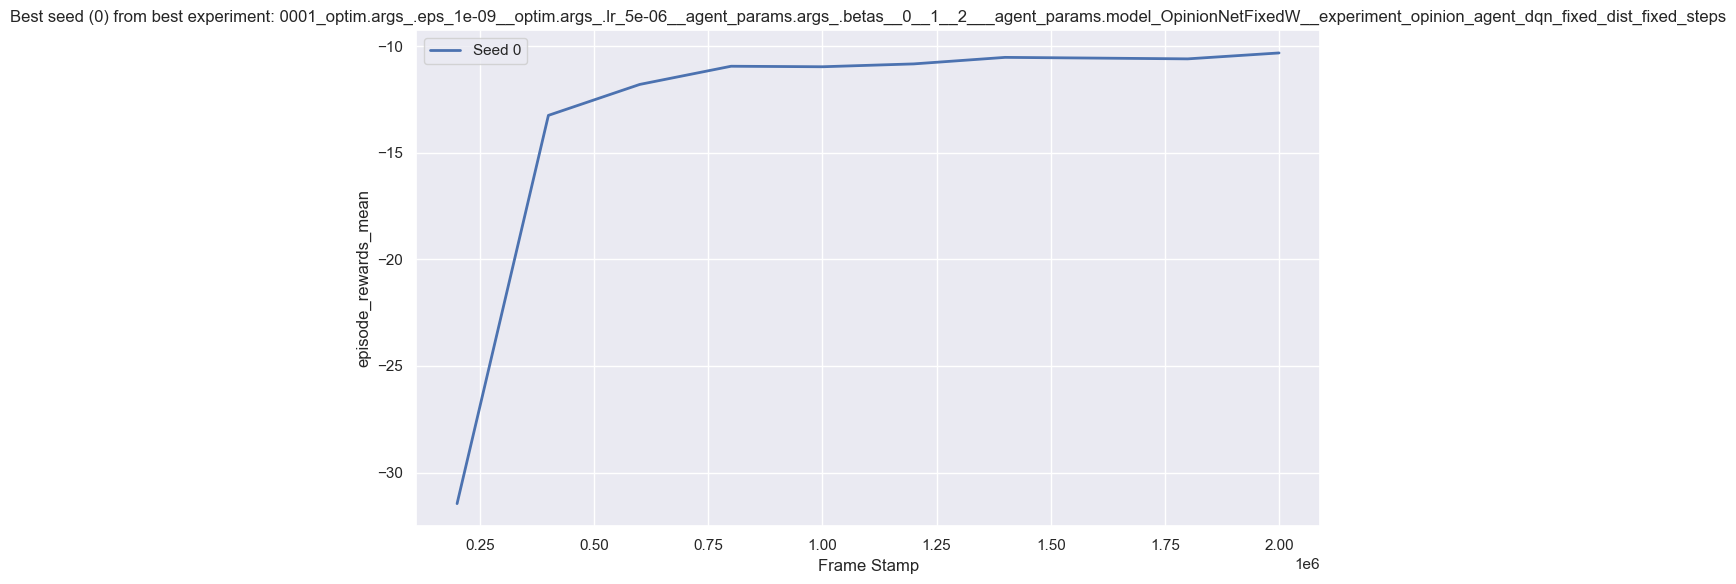

In [35]:
selected_metric = 'episode_rewards_mean'
hue_col = "experiment_name"

# Filter for training data only
# training_df = df[df['epoch_type'] == 'training']
training_df = df[df['epoch_type'] == 'validation']

# Step 1: Find best experiment
experiment_means = training_df.groupby(hue_col)[selected_metric].mean()
best_experiment = experiment_means.idxmax()

# Step 2: Filter to that experiment
best_exp_df = training_df[training_df[hue_col] == best_experiment]

# Step 3: Find best seed within best experiment
best_seed = (
    best_exp_df.groupby('seed')[selected_metric]
    .mean()
    .idxmax()
)

# Step 4: Filter to best seed
best_seed_df = best_exp_df[best_exp_df['seed'] == best_seed]

# Step 5: Plot
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=best_seed_df,
    x='frame_stamp',
    y=selected_metric,
    lw=2,
    label=f"Seed {best_seed}"
)

plt.title(f"Best seed ({best_seed}) from best experiment: {best_experiment}")
plt.ylabel(selected_metric)
plt.xlabel('Frame Stamp')
plt.legend()
plt.tight_layout()
plt.show()

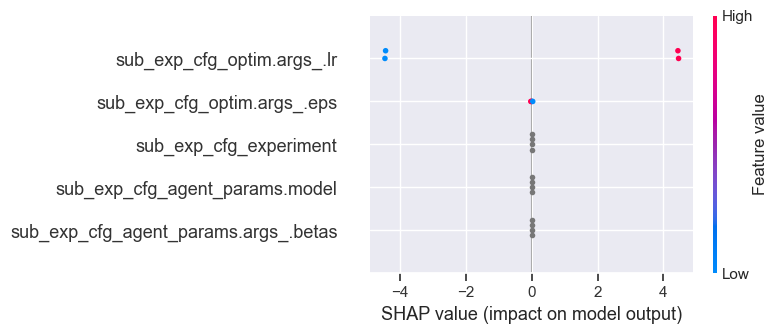

In [36]:
import shap
import xgboost
import pandas as pd


# Define the target metric and hyperparameter columns
target_metric = "episode_rewards_mean"  # Replace with actual metric column name
# Replace with actual hyperparameter column names

# Prepare data
X = sub_df[hyperparam_columns].apply(pd.to_numeric, errors='coerce')
y = sub_df[target_metric].fillna(3 * sub_df[target_metric].min())

# Train an XGBoost model to analyze feature importance
model = xgboost.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
model.fit(X, y)

# SHAP analysis
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Summary plot (feature importance)
shap.summary_plot(shap_values, X)

In [37]:
hyperparam_columns

['sub_exp_cfg_optim.args_.eps',
 'sub_exp_cfg_optim.args_.lr',
 'sub_exp_cfg_agent_params.args_.betas',
 'sub_exp_cfg_agent_params.model',
 'sub_exp_cfg_experiment']

In [38]:
import plotly.express as px

# Define readable names for selected hyperparams
readable_names = {
    hyperparam_columns[0]: "noise",
    hyperparam_columns[1]: "size"
}

# Rename columns in a copy of the dataframe
plot_df = sub_df.rename(columns=readable_names)

# Assign new column names
x_col = "noise"
y_col = "episode_rewards_mean"
facet_col = "size"

# Plot
fig = px.scatter(
    plot_df,
    x=x_col,
    y=y_col,
    color="experiment_name",  # Optional: color by experiment
    facet_col=facet_col,
    title="Episode Rewards vs. Noise Faceted by Size",
    height=600
)

fig.update_layout(showlegend=False)
fig.show()
